In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import znnl
import optax

from flax import linen as nn

import matplotlib.pyplot as plt
from znnl.regularizers import TraceRegularizer, NormRegularizer, Regularizer
from znnl.training_strategies import SimpleTraining

# Set up a model

In [4]:
data_generator = znnl.data.MNISTGenerator(ds_size=10)

In [5]:
class Network(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):        
        x = x.reshape((x.shape[0], -1))  # flatten
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

In [6]:
model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
        batch_size=34,
    )

train_recorder = znnl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    ntk=True,
    entropy= True, 
    trace=True,
    loss_derivative=True,
    update_rate=1, 
    chunk_size=1000
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = znnl.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    update_rate=1,
    chunk_size=1000
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

# Perform example study

In [7]:
def perform_study(regularizer: Regularizer):

    model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
    )

    train_recorder = znnl.training_recording.JaxRecorder(
        name="train_recorder",
        loss=True,
        accuracy=True,
        trace=True,
        entropy=True,
        update_rate=1, 
        chunk_size=1000
    )
    train_recorder.instantiate_recorder(
        data_set=data_generator.train_ds
    )


    test_recorder = znnl.training_recording.JaxRecorder(
        name="test_recorder",
        loss=True,
        accuracy=True,
        update_rate=1,
        chunk_size=1000
    )
    test_recorder.instantiate_recorder(
        data_set=data_generator.test_ds
    )

    trainer = SimpleTraining(
        model=model, 
        loss_fn=znnl.loss_functions.CrossEntropyLoss(),
        accuracy_fn=znnl.accuracy_functions.LabelAccuracy(), 
        recorders=[train_recorder, test_recorder],  
        regularizer=regularizer, 
        seed=0
    )

    _ = trainer.train_model(
        train_ds=data_generator.train_ds, 
        test_ds=data_generator.test_ds,
        batch_size=34,
        epochs=300,
    )

    train_report = train_recorder.gather_recording()
    test_report = test_recorder.gather_recording()

    return train_report, test_report

## Define a regularization schedule

A regularization schedule is a function that takes an epoch index (integer) and current 
regularization factor (float) as inputs and returns a new regularization factor as 
output (float).
The regularization factor is a value that defines the strength of the regularization. 
It is multiplied by the regularization penalty and then added to the model's loss during 
training.
The default schedule is to return the same constant value for each epoch (no change in
regularization). This is equivalent to having no regularization schedule, as the
regularization factor is not changed during training.

A simple example of an exponential decay schedule is:
```python
def reg_schedule_fn(epoch: int, reg_factor: float) -> float:
                        return reg_factor * 0.995 ** epoch
```
A schedule can also be written as a class:
```python
class RegSchedule:
    def __init__(self, reg_factor: float):
        super().__init__()
        self.reg_factor = reg_factor

    def __call__(self, epoch: int, *args):
        """
        Call the schedule function for a given epoch index.
        
        The here shown example exponentially increases to the initialized regularization
        factor.
        """
        return (1 - 0.995 ** epoch) * self.reg_factor
```

In [11]:
class RegSchedule:
    def __init__(self, reg_factor: float):
        super().__init__()
        self.reg_factor = reg_factor

    def __call__(self, epoch: int, *args):
        """
        Call the schedule function for a given epoch index.
        
        The here shown example exponentially increases to the initialized regularization
        factor.
        """
        return (1 - 0.995 ** epoch) * self.reg_factor

In [12]:
regularizers = [
    NormRegularizer(reg_factor=1e1, reg_schedule_fn=RegSchedule(reg_factor=1e1)),
    TraceRegularizer(reg_factor=5e-1, reg_schedule_fn=RegSchedule(reg_factor=5e-1)),
    None,
]

In [13]:
train_report_norm, test_report_norm = perform_study(regularizers[0])
train_report_trace, test_report_trace = perform_study(regularizers[1])
train_report_noreg, test_report_noreg = perform_study(regularizers[2])

Epoch: 300: 100%|████████████████████████████████| 300/300 [00:11<00:00, 26.83batch/s, accuracy=0.4]


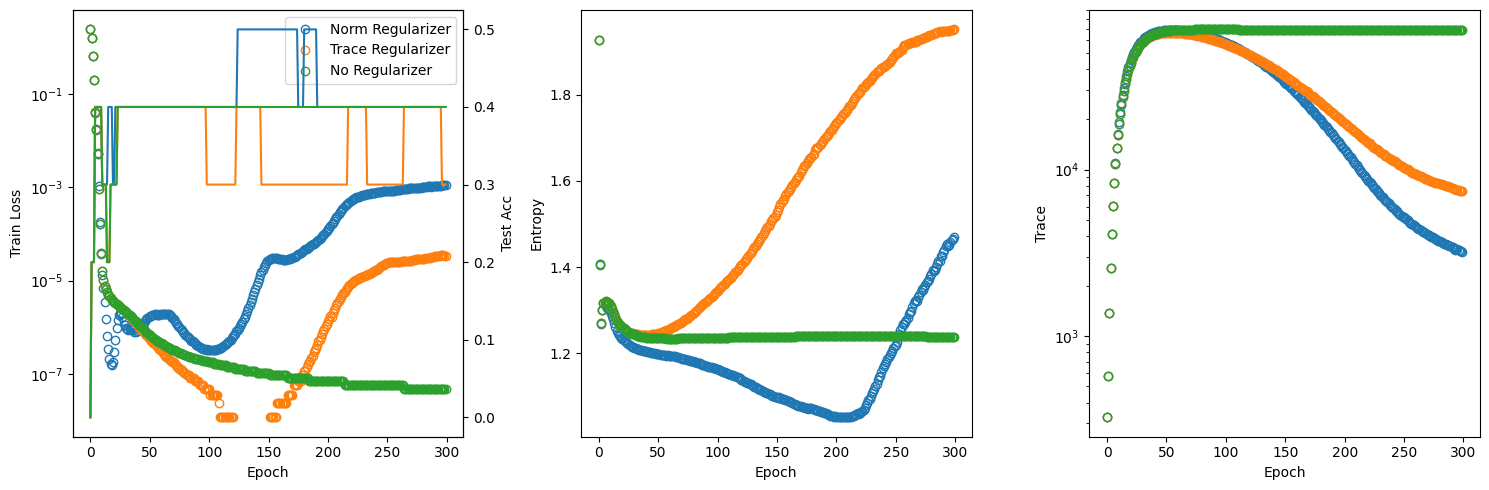

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

axs[0].plot(train_report_norm.loss, 'o', mfc='None', label="Norm Regularizer")
axs[0].plot(train_report_trace.loss, 'o', mfc='None', label="Trace Regularizer")
axs[0].plot(train_report_noreg.loss, 'o', mfc='None', label="No Regularizer")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[0].set_yscale("log")

axs_twinx = axs[0].twinx()
axs_twinx.plot(test_report_norm.accuracy, '-', mfc='None', label="Test Norm")
axs_twinx.plot(test_report_trace.accuracy, '-', mfc='None', label="Test Trace")
axs_twinx.plot(test_report_noreg.accuracy, '-', mfc='None', label="Test No Reg")
axs_twinx.set_ylabel("Test Acc")

axs[1].plot(train_report_norm.entropy, 'o', mfc='None', label="Norm")
axs[1].plot(train_report_trace.entropy, 'o', mfc='None', label="Trace")
axs[1].plot(train_report_noreg.entropy, 'o', mfc='None', label="No Reg")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Entropy")

axs[2].plot(train_report_norm.trace, 'o', mfc='None', label="Norm")
axs[2].plot(train_report_trace.trace, 'o', mfc='None', label="Trace")
axs[2].plot(train_report_noreg.trace, 'o', mfc='None', label="No Reg")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Trace")
axs[2].set_yscale("log")

axs[0].legend()
plt.show()